First, imports needed

In [1]:
import torch
import tqdm
from commander import load_model,get_model
import toolbox.vision as vision
import toolbox.losses as losses
import toolbox.metrics as metrics
import toolbox.searches as search
from toolbox.utils import tsp_get_min_dist,points_to_dist
from loaders.data_generator import TSP_Generator,TSP_custom_Generator
from loaders.siamese_loaders import siamese_loader
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sklearn.metrics as skmetrics

Here we initialize the parameters

In [2]:
model_path = "./runs/Fusion/TSP-Square01_EUC_2D_dataset_tsp/model_best.pth.tar"

arch = {'original_features_num': 2,
        'num_blocks': 5,
        'in_features': 128,
        'out_features': 1,
        'depth_of_mlp': 5,
        'arch' : "simple",
        'embedding': "edge"
}

gen_args = {'num_examples_train': 10,
            'n_vertices': 50,
            'generative_model': 'Square01',
            'distance_used': 'EUC_2D',
            'path_dataset': 'dataset_tsp'
}

In [3]:
model = get_model(arch)
model = load_model(model,'cpu',model_path)
model.eval() # Go faaast
print("#Parameters : ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Fetching model simple - edge embedding 
Reading model from  ./runs/Fusion/TSP-Square01_EUC_2D_dataset_tsp/model_best.pth.tar
#Parameters :  1354625


In [5]:
tspg = TSP_Generator('train',gen_args)
tspg.load_dataset()
data = tspg.data[:]
W_dists = torch.cat([elt[0] for elt in data])
#print(torch.mean(torch.min(W_dists,dim=-1)))

Reading dataset at dataset_tsp/TSP_Square01_EUC_2D_10_50/train.pkl


In [6]:
def eval_tsp(generator,model,path='figures/tsp',name='graph-'):
    loader = siamese_loader(generator, 1, generator.constant_n_vertices,shuffle=False)
    for i,(data,target) in tqdm.tqdm(enumerate(loader)):
        raw_scores = model(data).squeeze(-1)
        probas = torch.sigmoid(raw_scores)
        print(metrics.compute_f1(raw_scores,target,k_best=2))
        vision.show_proba_spring(probas[0],name=f'{name}-{i}-probas',path=path,iterations=10000)
        vision.show_proba_spring(probas[0],target[0],name=f'{name}-{i}-probas',path=path,iterations=10000)
        posx,posy = generator.positions[i] #Need shuffle False in loader
        vision.show_tour(posx,posy,target[0],path=path,name=f'{name}-{i}-baseline',with_labels=True)

0it [00:00, ?it/s](0.91, 0.91, 0.91)


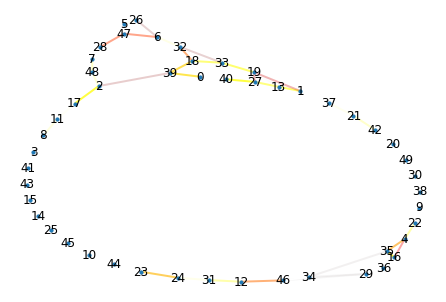

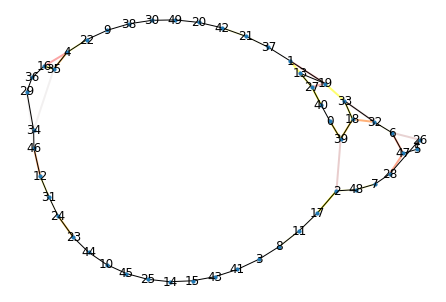

/home/mautrib/Programmation/projet-dldiy/graph_neural_net/toolbox/vision.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


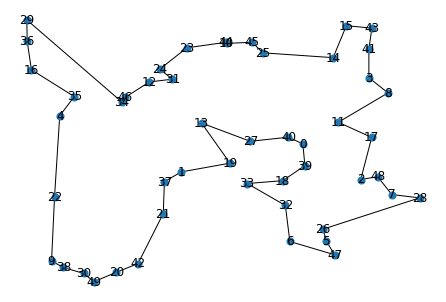

1it [00:12, 12.90s/it](0.95, 0.95, 0.9500000000000001)


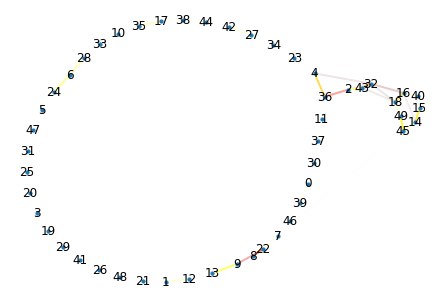

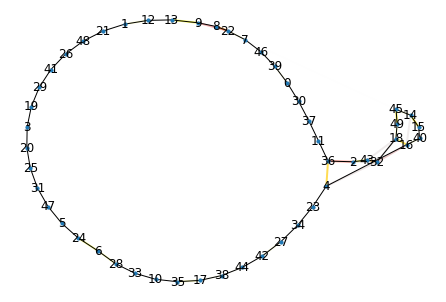

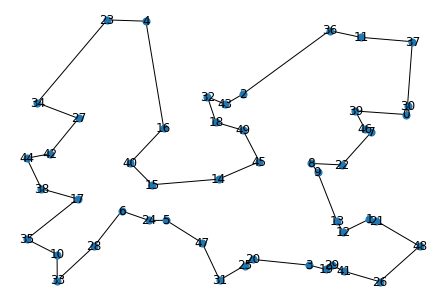

2it [00:23, 11.34s/it](0.86, 0.86, 0.8599999999999999)


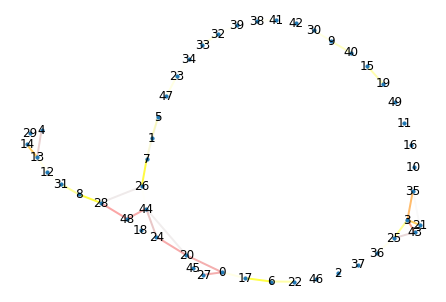

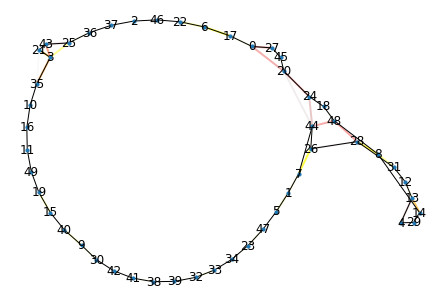

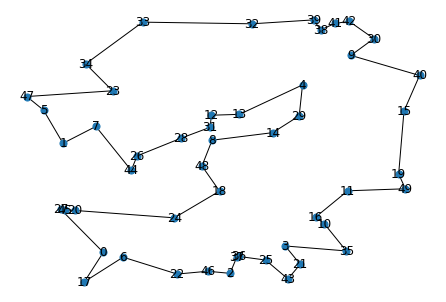

3it [00:33, 11.02s/it](0.93, 0.93, 0.93)


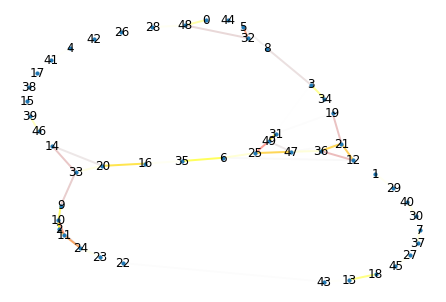

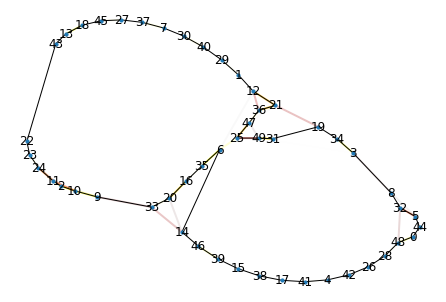

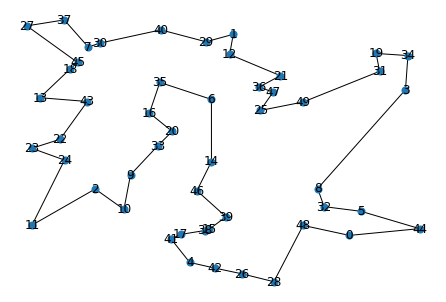

4it [00:44, 10.81s/it](0.88, 0.88, 0.88)


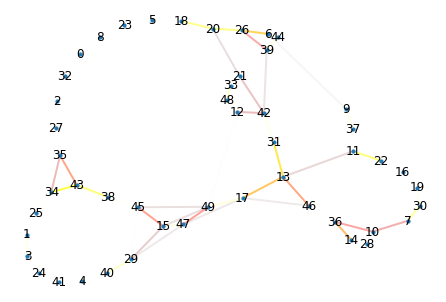

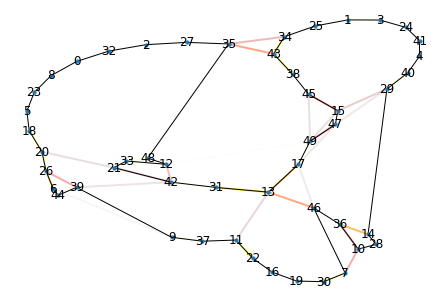

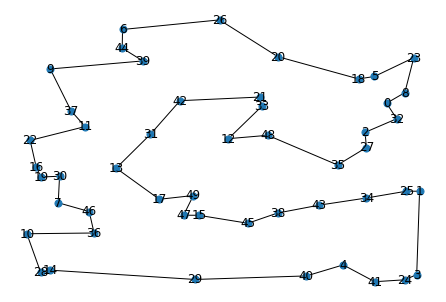

5it [00:53, 10.30s/it](0.9, 0.9, 0.9)


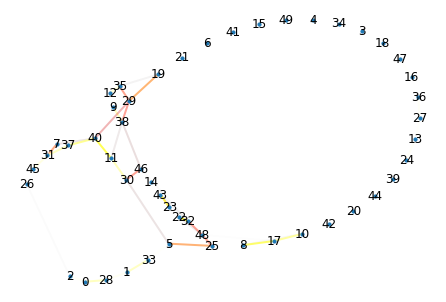

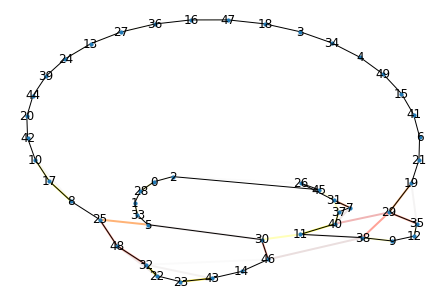

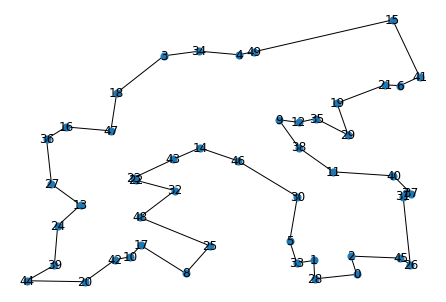

6it [01:03, 10.09s/it](0.85, 0.85, 0.85)


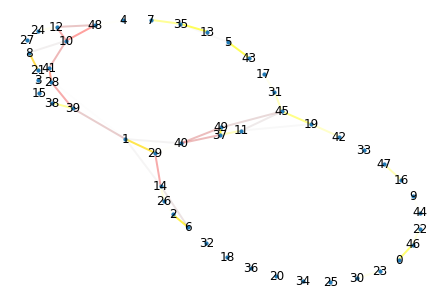

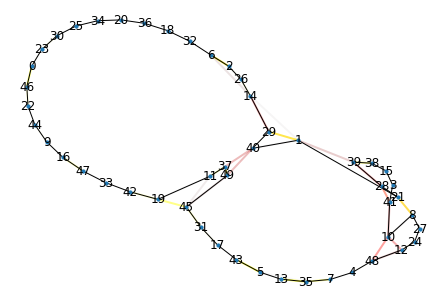

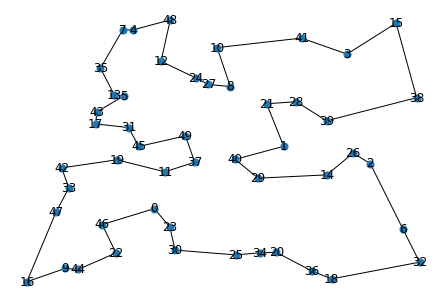

7it [01:12,  9.93s/it](0.84, 0.84, 0.8399999999999999)


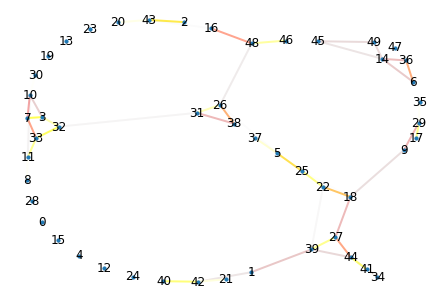

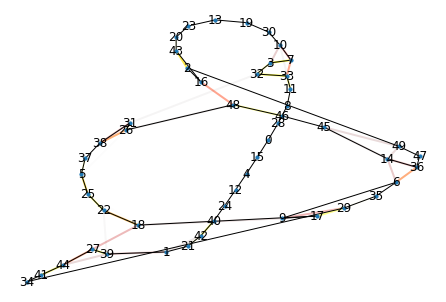

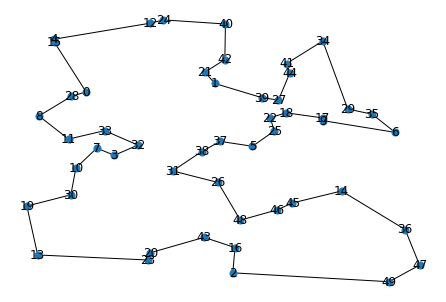

8it [01:22,  9.93s/it](0.8, 0.8, 0.8000000000000002)


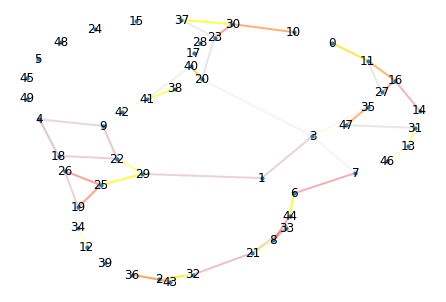

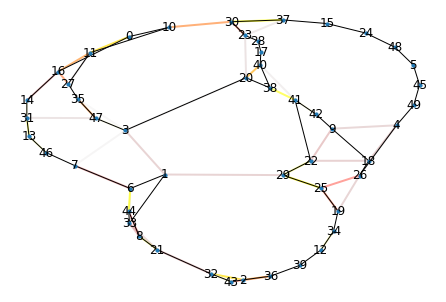

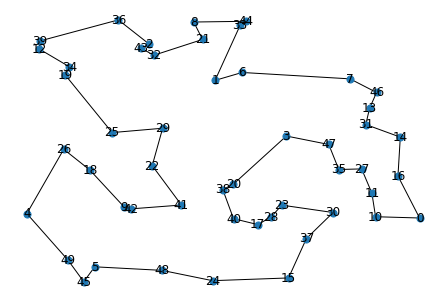

9it [01:32,  9.95s/it](0.81, 0.81, 0.81)


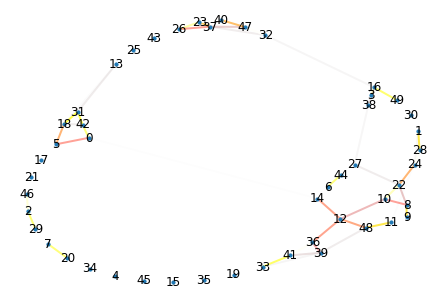

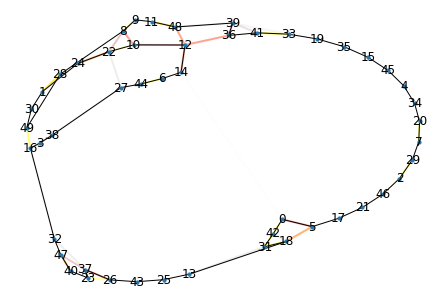

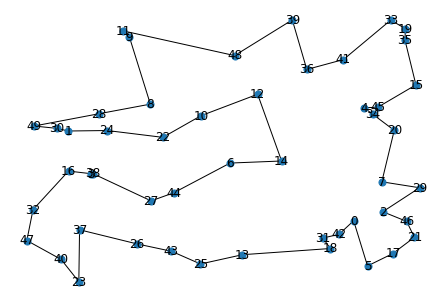

10it [01:43, 10.38s/it]


In [7]:
eval_tsp(tspg,model,name='TSP-50')

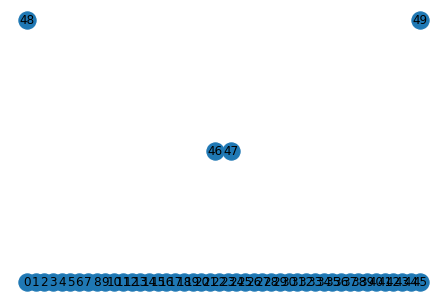

In [8]:
xs = [i/45 for i in range(46)] + [0.48,0.52,0,1]
ys = [0]*46 + [0.5,0.5,1,1]
n = len(xs)
pos = {i: (xs[i],ys[i]) for i in range(n)}
g = nx.empty_graph(n)
plt.figure()
nx.draw(g,pos=pos,with_labels=True)
plt.show()
plt.close()

In [9]:
custom_args = {
    'n_vertices': 50,
    'distance_used': 'EUC_2D',
    'path_dataset': 'dataset_tsp/'
}
custom_tspg = TSP_custom_Generator("custom",custom_args)
custom_tspg.custom_example(xs,ys)

0it [00:00, ?it/s](0.94, 0.94, 0.94)


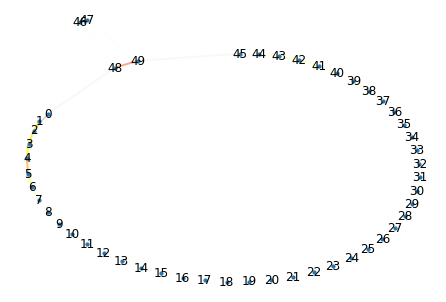

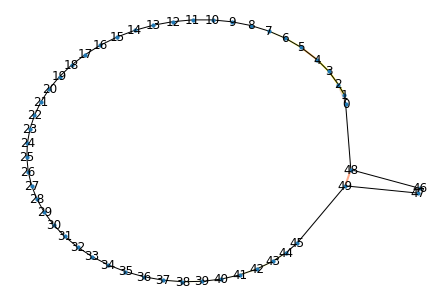

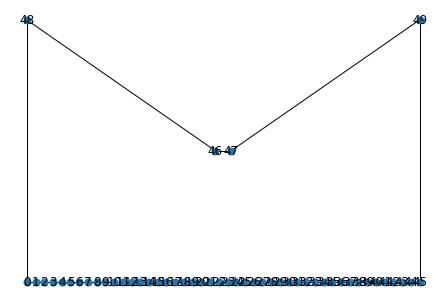

1it [00:21, 21.06s/it]


In [10]:
eval_tsp(custom_tspg,model,name='TSP-custom1')

In [11]:
from models.verbase_model import Verbose_Model
from models.layers import ColumnMaxPooling
verb = Verbose_Model(model)
_ = verb.eval()


In [12]:
xs = [i/12 for i in range(12)] + [1]*12 + [1-(i/12) for i in range(12)] + [0]*14
ys = [0]*12 + [i/12 for i in range(12)] + [1]*12 + [1-(i/14) for i in range(14)]
square_tspg = TSP_custom_Generator("square_custom",custom_args)
square_tspg.custom_example(xs,ys)

In [13]:
roc_args = {'num_examples_train': 1000,
            'n_vertices': 50,
            'generative_model': 'Square01',
            'distance_used': 'EUC_2D',
            'path_dataset': 'dataset_tsp'
}
bs = 8

In [14]:
roc_gen = TSP_Generator("train", roc_args)
roc_gen.load_dataset()
roc_loader = siamese_loader(roc_gen,bs,True,shuffle=False)

Reading dataset at dataset_tsp/TSP_Square01_EUC_2D_1000_50/train.pkl


In [15]:
l_auc = []
l_results = []
for data,target in tqdm.tqdm(roc_loader):
    raw_scores = model(data).squeeze()
    bs,n,_ = raw_scores.shape
    proba = torch.sigmoid(raw_scores)
    fpr, tpr, thresholds = skmetrics.roc_curve(target.reshape(bs*n*n).detach().numpy(), proba.reshape(bs*n*n).detach().numpy())
    l_results.append((fpr,tpr,thresholds))
    l_auc.append(skmetrics.auc(fpr,tpr))

100%|██████████| 125/125 [10:04<00:00,  4.84s/it]


Mean AUC over all examples 0.9981783934895834


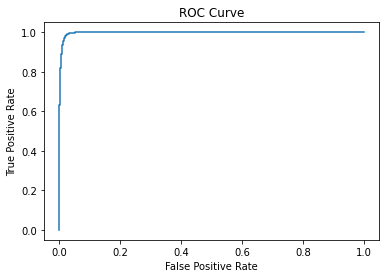

In [16]:
print(f"Mean AUC over all examples {np.mean(l_auc)}")
plt.figure()
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend()
plt.show()

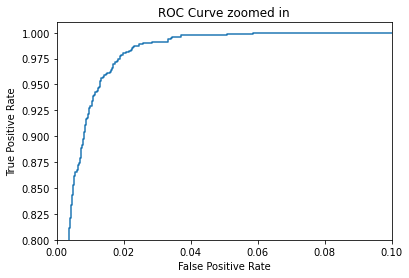

In [17]:
plt.figure()
plt.plot(fpr,tpr)
plt.title('ROC Curve zoomed in')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,0.1)
plt.ylim(0.8,1.01)
#plt.legend()
plt.show()

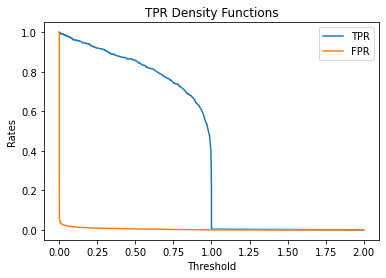

In [18]:
plt.figure()
plt.plot(thresholds,tpr,label='TPR')
plt.plot(thresholds,fpr,label='FPR')
plt.title('TPR Density Functions')
plt.xlabel('Threshold')
plt.ylabel('Rates')
plt.legend()
plt.show()

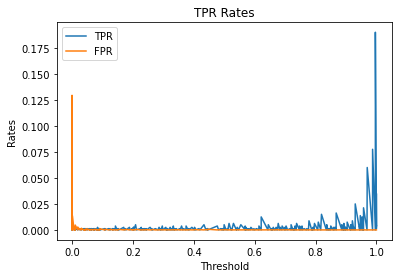

In [19]:
dtpr = [tpr[i] - tpr[i-1] for i in range(1,len(tpr))]
dfpr = [fpr[i] - fpr[i-1] for i in range(1,len(fpr))]
thresh_new = thresholds[1:]

plt.figure()
plt.plot(thresh_new,dtpr,label='TPR')
plt.plot(thresh_new,dfpr,label='FPR')
plt.title('TPR Rates')
plt.xlabel('Threshold')
plt.ylabel('Rates')
plt.legend()
plt.show()

In [4]:
gen_test_args = {'num_examples_test': 1000,
            'n_vertices': 50,
            'generative_model': 'Square01',
            'distance_used': 'EUC_2D',
            'path_dataset': 'dataset_tsp'
}
bs = 1
test_gen = TSP_Generator("test",gen_test_args)
test_gen.load_dataset()
test_loader = siamese_loader(test_gen,bs,True,shuffle=False)

Reading dataset at dataset_tsp/TSP_Square01_EUC_2D_1000_50/test.pkl


In [7]:
counter = 0
l_diff = []
l_inf_length = []
l_sol_length = []
for data,target in tqdm.tqdm(test_loader):
    bs,n,n = target.shape
    raw_scores = model(data).squeeze(-1)
    proba = torch.sigmoid(raw_scores)
    positions = test_gen.positions[counter:counter+bs]
    l_xs = [pos[0] for pos in positions]
    l_ys = [pos[1] for pos in positions]
    t_dist = [torch.tensor(points_to_dist(*pos)) for pos in positions]
    beams = search.tsp_beam_decode(raw_scores,l_xs,l_ys,b=1280)
    for k in range(bs):
        cur_beam = beams[k]
        cur_dist = t_dist[k]
        cur_target = target[k]
        inf_tour_length =  torch.sum(cur_beam*cur_dist)
        sol_tour_length = torch.sum(cur_target*cur_dist)
        l_diff.append((inf_tour_length-sol_tour_length).item()/sol_tour_length)
        l_inf_length.append(inf_tour_length)
        l_sol_length.append(sol_tour_length)
    counter+=bs

100%|██████████| 1000/1000 [1:12:30<00:00,  4.35s/it]


In [11]:
print(len(l_diff))
l_diff_reversed = [-diff for diff in l_diff]

1000


/home/mautrib/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


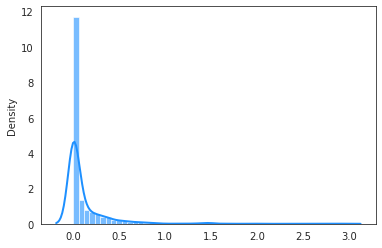

In [12]:
import seaborn as sns
sns.set_style("white")
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure()
sns.distplot(l_diff_reversed,color="dodgerblue", **kwargs)
plt.show()